In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os 
os.chdir('..')
import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.callbacks import TrackerCallback
from fastai.callbacks import CSVLogger
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from utils.mxresnet import *
from utils.ranger import *
from sklearn.model_selection import StratifiedKFold, KFold
from joblib import load, dump
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from efficientnet_pytorch import EfficientNet
import pretrainedmodels

In [2]:
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

In [3]:
FOLD = 0
NAME = 'EXP_50'
SUFFIX =f'SERESNEXT504_{FOLD}'
PATH = Path('../../../bengaliai')
SZ = 224
BS = 256
NFOLDS = 5 #keep the same split as the initial dataset
SEED = 2019
TRAIN_IMG = PATH/'img_trn_224'
LABELS = PATH/'train.csv'

os.chdir(NAME)

In [4]:
def strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = KFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

def multi_strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = MultilabelStratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

In [5]:
df = pd.read_csv(str(LABELS))
nunique = list(df.nunique())[1:-1]

In [6]:
val_idx = multi_strt_split(df['image_id'], df[df.columns[1:-1]].get_values())[FOLD]

/home/bukharih/.conda/envs/hb/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.
  """Entry point for launching an IPython kernel.


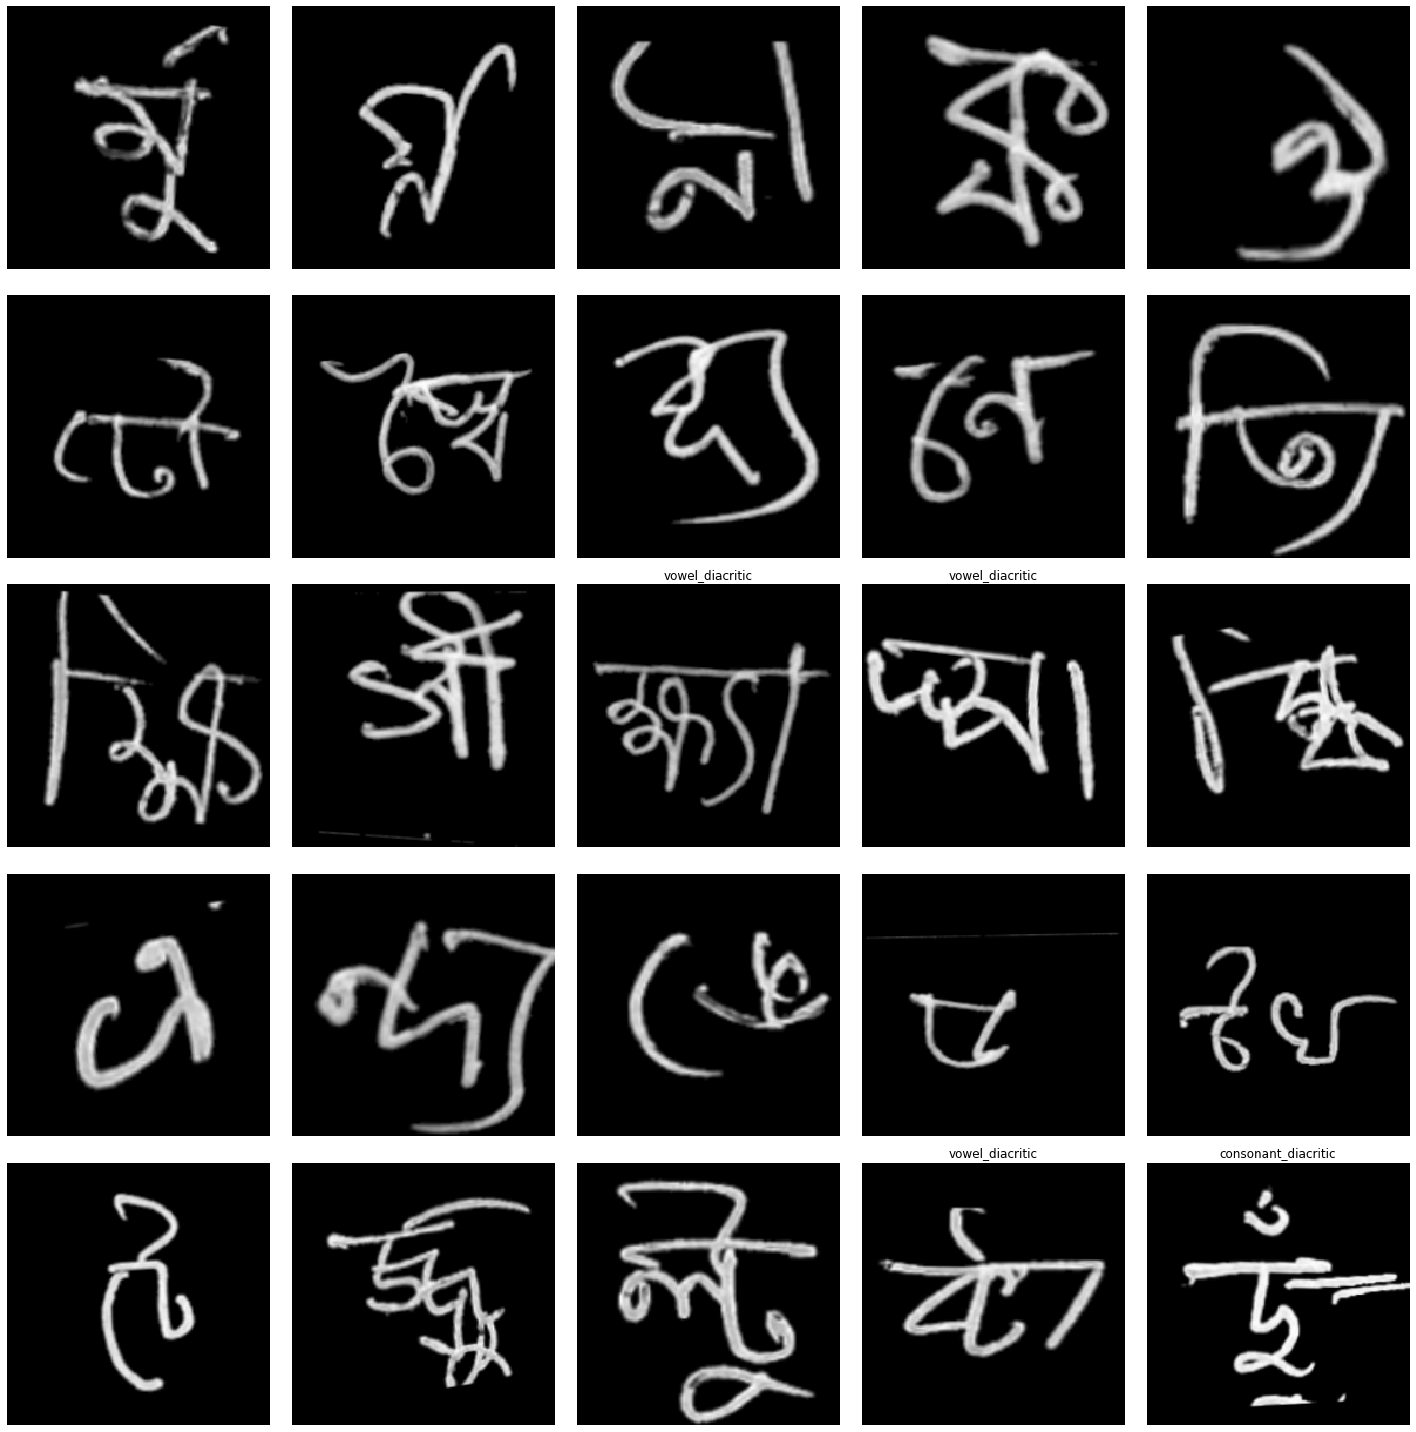

In [7]:
#imagenet_stats
data = (ImageList.from_df(df, path='', folder=TRAIN_IMG, suffix='.png', 
        cols='image_id', convert_mode='L')
        .split_by_idxs(valid_idx=val_idx[0], train_idx=val_idx[1])
        .label_from_df(cols=['grapheme_root','vowel_diacritic','consonant_diacritic'])
        .transform(get_transforms(do_flip=False,max_warp=0.1, max_zoom=1.2), size=SZ, padding_mode='zeros')
        .databunch(bs=BS)).normalize(imagenet_stats)

data.show_batch()

In [8]:
stats_ = data.stats
stats_

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [9]:
class Head(nn.Module):
    def __init__(self, nc, n, ps=0.2):
        super().__init__()
        layers = [AdaptiveConcatPool2d(), Mish(), Flatten()] + \
            bn_drop_lin(nc*2, 512, True, ps, nn.ReLU(inplace=True)) + \
            bn_drop_lin(512, n, True, ps)
        self.fc = nn.Sequential(*layers)
        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1.0)
                m.bias.data.zero_()
        
    def forward(self, x):
        return self.fc(x)
    
    
    
class CustomHead(nn.Module):
    def __init__(self, arch, cut, nc, n=nunique, pre=False, ps=0.5, activ_mish=True):
        super().__init__()
        self.body=nn.Sequential(*list(arch.children())[:cut])
        self.head1 = Head(nc,n[0])
        self.head2 = Head(nc,n[1])
        self.head3 = Head(nc,n[2])
        if activ_mish: 
            #to_Mish(self.body), 
            to_Mish(self.head1), to_Mish(self.head2), to_Mish(self.head3)
        
    def forward(self, x):
        x = self.body(x)
        x1 = self.head1(x)
        x2 = self.head2(x)
        x3 = self.head3(x)
        return x1, x2, x3
    


In [10]:
arch =  pretrainedmodels.se_resnext50_32x4d(num_classes=1000)
model = CustomHead(arch=arch, cut=-2, nc=2048)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /home/bukharih/.cache/torch/checkpoints/se_resnext50_32x4d-a260b3a4.pth
100%|██████████| 105M/105M [05:11<00:00, 355kB/s]  


In [12]:
class Loss_combine(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target):
        x1,x2,x3 = input
        y = target.long()
        return 2.0*F.cross_entropy(x1,y[:,0]) + F.cross_entropy(x2,y[:,1]) + \
          F.cross_entropy(x3,y[:,2])

In [13]:
class Metric_idx(Callback):
    def __init__(self, idx, average='macro'):
        super().__init__()
        self.idx = idx
        self.n_classes = 0
        self.average = average
        self.cm = None
        self.eps = 1e-9
        
    def on_epoch_begin(self, **kwargs):
        self.tp = 0
        self.fp = 0
        self.cm = None
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = last_output[self.idx]
        last_target = last_target[:,self.idx]
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.long().cpu()
        
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])) \
          .sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def _weights(self, avg:str):
        if self.n_classes != 2 and avg == "binary":
            avg = self.average = "macro"
            warn("average=`binary` was selected for a non binary case. \
                 Value for average has now been set to `macro` instead.")
        if avg == "binary":
            if self.pos_label not in (0, 1):
                self.pos_label = 1
                warn("Invalid value for pos_label. It has now been set to 1.")
            if self.pos_label == 1: return Tensor([0,1])
            else: return Tensor([1,0])
        elif avg == "micro": return self.cm.sum(dim=0) / self.cm.sum()
        elif avg == "macro": return torch.ones((self.n_classes,)) / self.n_classes
        elif avg == "weighted": return self.cm.sum(dim=1) / self.cm.sum()
        
    def _recall(self):
        rec = torch.diag(self.cm) / (self.cm.sum(dim=1) + self.eps)
        if self.average is None: return rec
        else:
            if self.average == "micro": weights = self._weights(avg="weighted")
            else: weights = self._weights(avg=self.average)
            return (rec * weights).sum()
    
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, self._recall())
    
Metric_grapheme = partial(Metric_idx,0)
Metric_vowel = partial(Metric_idx,1)
Metric_consonant = partial(Metric_idx,2)

class Metric_tot(Callback):
    def __init__(self):
        super().__init__()
        self.grapheme = Metric_idx(0)
        self.vowel = Metric_idx(1)
        self.consonant = Metric_idx(2)
        
    def on_epoch_begin(self, **kwargs):
        self.grapheme.on_epoch_begin(**kwargs)
        self.vowel.on_epoch_begin(**kwargs)
        self.consonant.on_epoch_begin(**kwargs)
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        self.grapheme.on_batch_end(last_output, last_target, **kwargs)
        self.vowel.on_batch_end(last_output, last_target, **kwargs)
        self.consonant.on_batch_end(last_output, last_target, **kwargs)
        
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, 0.5*self.grapheme._recall() +
                0.25*self.vowel._recall() + 0.25*self.consonant._recall())

In [14]:

learn = Learner(data, model, loss_func=Loss_combine(),
        metrics=[Metric_grapheme(),Metric_vowel(),Metric_consonant(),Metric_tot()])
learn.model = nn.DataParallel(learn.model)

learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time


/home/bukharih/.conda/envs/hb/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  if __name__ == '__main__':


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


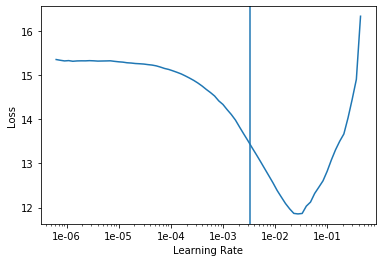

In [15]:
lr = 1e-2/3
learn.recorder.plot()
plt.axvline(lr)

In [16]:
learn.unfreeze()
learn.fit_one_cycle(10, lr, wd=1e-2,
                    callbacks = [SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{NAME}_{SUFFIX}_{FOLD}')])

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,1.185492,1.423012,0.800531,0.927900,0.914025,0.860747,10:49
1,1.113683,1.095394,0.866611,0.938300,0.931134,0.900664,10:47
2,0.942867,0.862008,0.882481,0.956638,0.939664,0.915316,10:47
3,0.687940,0.696356,0.908442,0.974215,0.965428,0.939132,10:47
4,0.561223,0.570645,0.921570,0.969195,0.945501,0.939459,10:47
5,0.430569,0.445175,0.943159,0.979435,0.976194,0.960487,10:47
6,0.317970,0.402432,0.950688,0.981624,0.979919,0.965730,10:47
7,0.202935,0.358761,0.954624,0.984797,0.981684,0.968932,10:47
8,0.157703,0.342496,0.956501,0.985814,0.984142,0.970739,10:47
9,0.120078,0.340506,0.957946,0.985999,0.983571,0.971365,10:47


/home/bukharih/.conda/envs/hb/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  if __name__ == '__main__':


Better model found at epoch 0 with valid_loss value: 1.4230117797851562.
Better model found at epoch 1 with valid_loss value: 1.0953943729400635.
Better model found at epoch 2 with valid_loss value: 0.8620080947875977.
Better model found at epoch 3 with valid_loss value: 0.6963560581207275.
Better model found at epoch 4 with valid_loss value: 0.5706449747085571.
Better model found at epoch 5 with valid_loss value: 0.44517460465431213.
Better model found at epoch 6 with valid_loss value: 0.4024317264556885.
Better model found at epoch 7 with valid_loss value: 0.3587614595890045.
Better model found at epoch 8 with valid_loss value: 0.3424963355064392.
Better model found at epoch 9 with valid_loss value: 0.3405064046382904.


In [ ]:
!sudo shutdown